<a href="https://colab.research.google.com/github/miraytopal/AdventureWorks-DB-SQL-Queries-and-PowerBi/blob/main/RFM_Customer_Segmentation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Variables Description:**

- InvoiceNo : The number of the invoice, unique per each purchase. Refund invoice numbers contain "C"

- StockCode : Unique code per each item

- Description : Name of the item

- Quantity : The number of items within the invoice

- InvoiceDate : Date and time of the purchase

- UnitPrice : Price of a single item, as of Sterlin

- CustomerID : Unique id number per each customer

- Country : The country where the customer is living

###1.READING and UNDERSTANDING THE DATASET

In [ ]:
# Importing necessary libraries
import numpy as np 
import pandas as pd 
import datetime as dt
from datetime import timedelta

# plot
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv("/content/Year_2010_2011.csv",  encoding= 'unicode_escape')

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
def summary(df):
    display(df.head())
    print('-'*120)
    display(df.info())
    print('-'*120)
    display(df.describe([0.01,0.25,0.50,0.75,0.99]))
summary(df)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49912 entries, 0 to 49911
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      49912 non-null  object 
 1   StockCode    49912 non-null  object 
 2   Description  49770 non-null  object 
 3   Quantity     49912 non-null  int64  
 4   InvoiceDate  49912 non-null  object 
 5   Price        49912 non-null  float64
 6   Customer ID  32030 non-null  float64
 7   Country      49911 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.0+ MB


None

------------------------------------------------------------------------------------------------------------------------


,Quantity,Price,Customer ID
count,49912.000000,49912.000000,32030.000000
mean,8.294218,6.423659,15426.016422
std,55.576019,166.651451,1752.300279
min,-9360.000000,0.000000,12347.000000
1%,-2.000000,0.210000,12415.000000
25%,1.000000,1.250000,14057.000000
50%,2.000000,2.510000,15464.000000
75%,8.000000,4.250000,17041.000000
99%,96.000000,20.380000,18168.000000
max,2880.000000,16888.020000,18283.000000


In [ ]:
df['Customer ID'].nunique()

1038

In [ ]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

Invoice         0.00
StockCode       0.00
Description     0.28
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    35.83
Country         0.00
dtype: float64

In [ ]:
# Let's drop all Nulls  
df.dropna(inplace=True)

# 'Invoice Id' contains value "C" when the transaction is returned
# We'll remove the returned transactions 
df = df[~df['Invoice'].str.contains('C', na=False)]

# We don't want negative quantity and price in our dataset
df = df[(df.Quantity > 0) & (df.Price > 0)]

In [ ]:
# Unique number of Customer ID
df['Customer ID'].nunique()

972

In [ ]:
# checking shape of the dataset
df.shape

(31145, 8)

In [ ]:
# Creating ‘Total Price’ Column
df['TotalPrice'] = df['Price'] * df['Quantity']
df.drop(['Price', 'Quantity'], axis=1, inplace=True)

In [ ]:
# to delete duplicate records
df = df.drop_duplicates()

In [ ]:
# top buying countries
df.groupby("Country").agg({"TotalPrice":"sum"}).sort_values("TotalPrice", ascending = False).head()

,TotalPrice
Country,
United Kingdom,591355.34
Germany,19181.87
France,12985.60
EIRE,8813.88
Netherlands,8784.48


In [ ]:
# best selling products
df.groupby("Description").agg({"TotalPrice":"sum"}).sort_values("TotalPrice", ascending = False).head()

,TotalPrice
Description,
REGENCY CAKESTAND 3 TIER,20219.40
WHITE HANGING HEART T-LIGHT HOLDER,12124.35
CHILLI LIGHTS,10071.34
WOOD BLACK BOARD ANT WHITE FINISH,7039.83
VINTAGE UNION JACK MEMOBOARD,6978.29


###2.DATA PREPARATION

We'll define 3 factors:

- R(Recency): Number of days since last purchase
- F(Frequency): Number of transactions
- M(Monetary): Total amount of transactions

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
# let's see the latest transaction day 
df.InvoiceDate.max()

Timestamp('2011-01-09 14:36:00')

In [ ]:
# We'll add 2 days to the latest transaction day
max_date = df.InvoiceDate.max() + timedelta(days=2)
max_date

Timestamp('2011-01-11 14:36:00')

In [ ]:
rfm = df.groupby('Customer ID').agg({
                              'InvoiceDate': lambda InvoiceDate: (max_date - InvoiceDate.max()).days,
                              'Invoice': lambda Invoice: Invoice.nunique(),
                              'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [ ]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [ ]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12347.0,34,1,711.79
12348.0,25,1,892.80
12370.0,25,2,1864.27
12377.0,22,1,1001.52
12383.0,20,1,600.72


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103

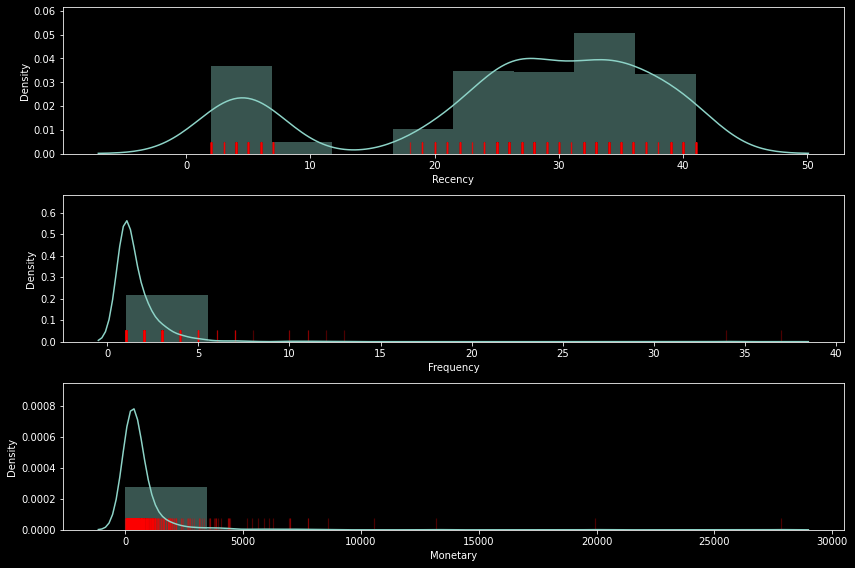

In [ ]:
# Recency, Frequency and Monetary visualization
plt.style.use('dark_background')
f,ax = plt.subplots(figsize=(12, 8))

plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency', bins=8, kde=True, rug=True, 
                                   rug_kws={"color": "r", "alpha": 0.3, "linewidth": 1.2, "height":0.08, 'expand_margins':bool})

plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency', bins=8, kde=True, rug=True, 
                                   rug_kws={"color": "r", "alpha": 0.3, "linewidth": 1.2, "height":0.08, 'expand_margins':bool})

plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary', bins=8, kde=True, rug=True, 
                                   rug_kws={"color": "r", "alpha": 0.3, "linewidth": 1.2, "height":0.08, 'expand_margins':bool})

plt.tight_layout()
plt.show();

###3.CUSTOMER SEGMENTATION

In [ ]:
# High monetary and frequency are positive indicators of customer loyalty, but recency has the opposite effect.
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])
rfm['RFM_Score'] = rfm['R'].astype(str) +rfm['F'].astype(str) + rfm['M'].astype(str)

In [ ]:
# Segmentation by RFM scores
segmentation_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [ ]:
rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(segmentation_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
Customer ID,,,,,,,,
12347.0,34,1,711.79,2,1,4,214,Hibernating
12348.0,25,1,892.80,4,1,5,415,Promising
12370.0,25,2,1864.27,4,4,5,445,Loyal Customers
12377.0,22,1,1001.52,4,1,5,415,Promising
12383.0,20,1,600.72,4,1,4,414,Promising


In [ ]:
# let's take a look at the RFM values of each segment 
rfm.groupby('Segment').mean().sort_values('Monetary', ascending=False)

,Recency,Frequency,Monetary
Segment,,,
Can't Loose,35.931034,3.551724,1877.792414
Champions,4.593220,3.423729,1644.986949
Loyal Customers,25.850000,2.455556,1046.286000
New Customers,4.333333,1.000000,837.492000
Promising,23.093023,1.000000,452.680233
About to Sleep,29.441558,1.000000,395.274156
At Risk,36.591837,1.136054,379.769456
Potential Loyalists,16.133333,1.000000,335.390167
Hibernating,36.817143,1.000000,325.475086


###4.CONCLUSION

In [ ]:
# number of customers of each segment
rfm['Segment'].value_counts().to_frame('Count')

,Count
Loyal Customers,180
Hibernating,175
At Risk,147
Potential Loyalists,120
Champions,118
About to Sleep,77
Need Attention,53
Promising,43
New Customers,30
Can't Loose,29


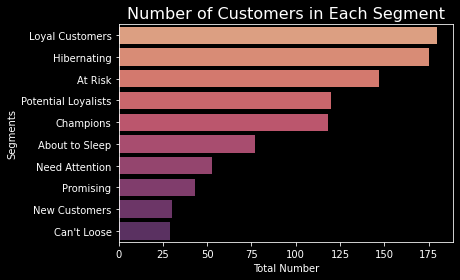

In [ ]:
# plot
sns.barplot(x='Count', y='index', data=rfm['Segment'].value_counts().to_frame('Count').reset_index(), palette='flare')
plt.xlabel('Total Number')
plt.ylabel('Segments')
plt.title('Number of Customers in Each Segment', size=16);

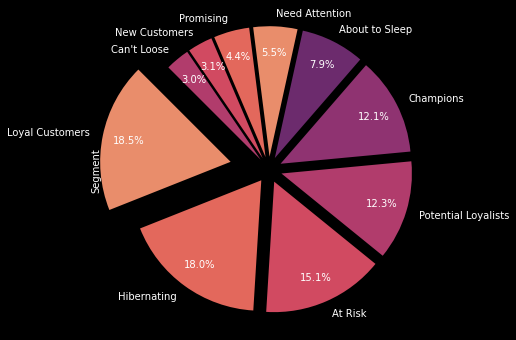

In [ ]:
explodes = [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
rfm['Segment'].value_counts().plot.pie(subplots=True, 
                                       figsize=(6, 6), 
                                       pctdistance=0.8, 
                                       startangle=135, 
                                       autopct='%1.1f%%', 
                                       colors=sns.color_palette('flare'),
                                       explode = explodes);

In [ ]:
rfm[['Segment', 'Recency', 'Frequency', 'Monetary']].groupby('Segment').agg(['mean', 'count', 'sum'])

Recency             Frequency                Monetary  \
                          mean count   sum      mean count  sum         mean   
Segment                                                                        
About to Sleep       29.441558    77  2267  1.000000    77   77   395.274156   
At Risk              36.591837   147  5379  1.136054   147  167   379.769456   
Can't Loose          35.931034    29  1042  3.551724    29  103  1877.792414   
Champions             4.593220   118   542  3.423729   118  404  1644.986949   
Hibernating          36.817143   175  6443  1.000000   175  175   325.475086   
Loyal Customers      25.850000   180  4653  2.455556   180  442  1046.286000   
Need Attention       29.094340    53  1542  1.000000    53   53   319.760943   
New Customers         4.333333    30   130  1.000000    30   30   837.492000   
Potential Loyalists  16.133333   120  1936  1.000000   120  120   335.390167   
Promising            23.093023    43   993  1.000000    43   43   452.680233   

                                      
                    count        sum  
Segment                               
About to Sleep         77   30436.11  
At Risk               147   55826.11  
Can't Loose            29   54455.98  
Champions             118  194108.46  
Hibernating           175   56958.14  
Loyal Customers       180  188331.48  
Need Attention         53   16947.33  
New Customers          30   25124.76  
Potential Loyalists   120   40246.82  
Promising              43   19465.25

###5.RECOMMENDATION

- Most of our customers are loyal to our brand. To remain that, we must try to make them feel special and try to bring them into the champions segment.

- Another large part of our customers are in the 'Hibernate' and 'At Risk' segments. This has some financial risks for our Brand. We need to protect our customers, we can run some campaigns targeting these customers and send them personalized emails/messages/notifications to encourage them to order.
